### MAST30034: Applied Data Science Project 1
---
# Data Analysis: FHVHV Dataset
#### Xavier Travers (1178369)

Performs data analysis to relate the COVID dataset and FHVHV aggregate dataset

In [1]:
# imports used throughout this notebook
from pyspark.sql import DataFrame, Column
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import os

DEBUGGING = False

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 XT Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)

22/08/06 22:01:12 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.20.188.223 instead (on interface eth0)
22/08/06 22:01:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/06 22:01:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# read in the aggregated dataset
fhvhv_df = spark.read.parquet('../data/curated/tlc/aggregated/fhvhv')
# create a view
fhvhv_df.createOrReplaceTempView("fhvhv")

In [4]:
# fhvhv_df = pd.read_parquet('../data/curated/tlc/aggregated')

In [5]:
# sort by year, month, type
fhvhv_df = fhvhv_df.sort('year', 'month', 'type')

In [6]:
# sanity check on read
fhvhv_df.limit(5)

year,month,type,PUborough,DOborough,shared,total_trips,total_distance,avg_distance
2019,6,juno,Brooklyn,EWR,0.0,607,11811.460000000008,19.458747940691943
2019,6,juno,Staten Island,Staten Island,0.0,1957,6770.839999999994,3.4598058252427153
2019,6,juno,Staten Island,Bronx,0.0,17,575.15,33.83235294117647
2019,6,juno,Brooklyn,Manhattan,0.0,23352,161493.3300000001,6.9156102261048344
2019,6,juno,Bronx,Staten Island,0.0,11,363.85999999999996,33.07818181818181


In [7]:
# read in the covid dataset
covid_df = spark.read.parquet('../data/curated/covid/cases-by-month')
# create a view
covid_df.createOrReplaceTempView("covid")

In [8]:
# sanity check on read
covid_df.limit(5)

year,month,num_days,total_case_count,total_hospitalized_count,total_death_count,avg_case_count,avg_hospitalized_count,avg_death_count,borough
2020,3,31,9538,2730,287,307.6774193548387,88.06451612903226,9.258064516129032,Manhattan
2020,4,30,11741,3863,1623,391.3666666666667,128.76666666666668,54.1,Manhattan
2020,5,31,3795,545,391,122.41935483870968,17.580645161290324,12.612903225806452,Manhattan
2020,6,30,1733,208,98,57.766666666666666,6.933333333333334,3.2666666666666666,Manhattan
2020,7,31,1920,174,39,61.935483870967744,5.612903225806452,1.2580645161290323,Manhattan


In [9]:
def joinOnBoroughs(tlc_df, covid_df):
    tlc_df.createOrReplaceTempView('tlc')

    col_selections = f'''
    tlc.year,
    tlc.month,
    tlc.type,
    tlc.PUborough,
    tlc.DOborough,
    tlc.shared,
    tlc.total_trips,
    tlc.avg_distance,
    tlc.total_distance,
    pu.num_days,
    pu.total_case_count AS pu_total_case_count,
    pu.total_hospitalized_count AS pu_total_hospitalized_count,
    pu.total_death_count AS pu_total_death_count,
    pu.avg_case_count AS pu_avg_case_count,
    pu.avg_hospitalized_count AS pu_avg_hospitalized_count,
    pu.avg_death_count AS pu_avg_death_count,
    do.total_case_count AS do_total_case_count,
    do.total_hospitalized_count AS do_total_hospitalized_count,
    do.total_death_count AS do_total_death_count,
    do.avg_case_count AS do_avg_case_count,
    do.avg_hospitalized_count AS do_avg_hospitalized_count,
    do.avg_death_count AS do_avg_death_count
    '''

    covid_df.createOrReplaceTempView('covid')

    return spark.sql(
    f'''
    SELECT {col_selections}
    FROM tlc, covid AS pu, covid AS do
    WHERE tlc.year == pu.year
    AND tlc.month == pu.month
    AND tlc.PUborough == pu.borough
    AND tlc.year == do.year
    AND tlc.month == do.month
    AND tlc.PUborough == do.borough
    '''
)

In [10]:
# join the datasets on PUBorough and DOBorough
joint_df = joinOnBoroughs(fhvhv_df, covid_df)

In [11]:
# sanity check on join
joint_df.limit(5)

year,month,type,PUborough,DOborough,shared,total_trips,avg_distance,total_distance,num_days,pu_total_case_count,pu_total_hospitalized_count,pu_total_death_count,pu_avg_case_count,pu_avg_hospitalized_count,pu_avg_death_count,do_total_case_count,do_total_hospitalized_count,do_total_death_count,do_avg_case_count,do_avg_hospitalized_count,do_avg_death_count
2020,3,lyft,Staten Island,Bronx,0.0,85,33.158929411764696,2818.508999999999,31,4461,750,111,143.90322580645162,24.193548387096776,3.5806451612903225,4461,750,111,143.90322580645162,24.193548387096776,3.5806451612903225
2020,3,lyft,Staten Island,Bronx,1.0,13,32.19084615384615,418.481,31,4461,750,111,143.90322580645162,24.193548387096776,3.5806451612903225,4461,750,111,143.90322580645162,24.193548387096776,3.5806451612903225
2020,3,via,Queens,Queens,1.0,793,6.02672131147541,4779.1900000000005,31,19983,6000,656,644.6129032258065,193.5483870967742,21.161290322580644,19983,6000,656,644.6129032258065,193.5483870967742,21.161290322580644
2020,3,via,Brooklyn,Bronx,1.0,56,16.89696428571428,946.2299999999996,31,18516,5319,662,597.2903225806451,171.58064516129033,21.35483870967742,18516,5319,662,597.2903225806451,171.58064516129033,21.35483870967742
2020,3,uber,Manhattan,Queens,0.0,263591,10.971429942600555,2891970.1900000228,31,9538,2730,287,307.6774193548387,88.06451612903226,9.258064516129032,9538,2730,287,307.6774193548387,88.06451612903226,9.258064516129032


In [ ]:
# define the types of fhvhv companies
FHVHV_TYPES = [
    'uber',
    '']

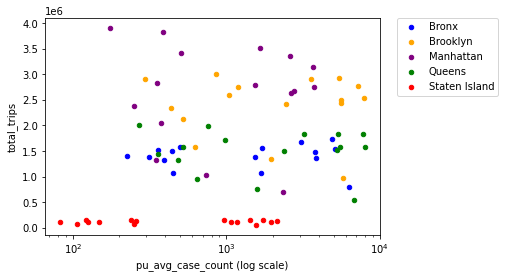

In [12]:
import sys
sys.path.insert(1, '../scripts')
from helpers.plot_helpers import group_plot

# iterate over the 4 major fhvhv companies and generate scatter plots of trips vs avg cases monthly

pandas_df = joint_df\
    .groupBy('year', 'month', 'type', 'PUborough', 'num_days')\
    .agg(
        F.sum('pu_total_case_count').alias('pu_total_case_count'),
        (F.sum('pu_total_case_count') / F.col('num_days')).alias('pu_avg_case_count'),
        F.sum('total_trips').alias('total_trips')
    )\
    .where((F.col('type') == 'uber'))\
    .toPandas()
group_plot(pandas_df, 'pu_avg_case_count', 'total_trips', 'PUborough', 'fhvhv-uber',
    logx=True)


### 1. Total monthly trips versus COVID case rates

Starts with a scatter plot, then chooses an applicable form of regression.
Also performs hypothesis tests to determine the reliability of the selected regression model.

In [13]:
#